#### Importing necessary libraries

In [1]:
#PyTorch specific
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

#Data Manipulation specific
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from scipy import signal

#Visualisation specific
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

### Section 1: Invoking CDS API

In [2]:
url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = 'key: 65473:9fc228e7-4bcd-493f-b516-f714886682d7'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: 65473:9fc228e7-4bcd-493f-b516-f714886682d7


In [3]:
!pip install cdsapi

  Created wheel for cdsapi: filename=cdsapi-0.3.1-py2.py3-none-any.whl size=11660 sha256=8b7d82b32909ec98cb5a1e94c97a4404dc4b69ec20be6a15f5a4ac523343feda
  Stored in directory: /root/.cache/pip/wheels/8c/d5/29/58ea64525211fb1189b2e0e5696255c4c51bd2e5262c35cc17
Successfully built cdsapi


Generating API request by selecting the required vairables and constraints and then copy pasting the API request code snippet from [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) to download the three datasets

In [4]:
#Mounting google drive to access and store datasets
from google.colab import drive
drive.mount('/content/drive')

#If dataset is already downloaded in google drive, uncomment the following line and copy to colab workspace
!cp '/content/drive/My Drive/Drive1/datasets/datasets.nc' '/content'

Mounted at /content/drive


In [ ]:
#If dataset isn't downloaded, download and store in google drive
'''import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'total_precipitation', 'volumetric_soil_water_layer_1',
        ],
      "product_type": "reanalysis",
        'month': '12',
        'year': '2019',
        'time': '12:00',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
    },
    'datasets.nc')

!cp '/content/datasets.nc' '/content/drive/My Drive/Drive1/datasets' '''

In [5]:
ds = xr.open_dataset("datasets.nc")
ds

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2019-12-01T12:00:00 ... 2019-12-31T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-29 10:56:21 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

As expected, we have a xarray type dataset that has three data variables which are individual xarray type arrays, also referred to as individual datasets.

Here coordinates represent the three dimensions and the paricular value in one of the array (t2m, tp, swvl1) represents the particular data value in that exact time (time dimension) and position (latitudde and longitude).

Let's explore each of the three dataset/arrays one by one and see what kind of values they hold

### Section 2: Exploratory Data Analysis (EDA) & Visualzations

In [6]:
t2m = ds['t2m']
tp = ds['tp']
swvl1 = ds['swvl1']

In [37]:
print(t2m[:,:,:].shape)
print(t2m[:,:,:].values)

(31, 1801, 3600)
[[[      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  ...
  [241.74368 241.74368 241.74368 ... 241.74368 241.74368 241.74368]
  [241.74222 241.74222 241.74222 ... 241.74222 241.74222 241.74222]
  [241.6848  241.6848  241.6848  ... 241.6848  241.6848  241.6848 ]]

 [[      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  ...
  [242.85974 242.85828 242.85828 ... 242.85828 242.85828 242.85828]
  [242.84796 242.8465  242.8465  ... 242.84355 242.8465  242.8465 ]
  [242.34442 242.34442 242.34442 ... 242.34442 242.34442 242.34442]]

 [[      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  [      nan   

In [38]:
print(tp[:,:,:].shape)
print(tp[:,:,:].values)

(31, 1801, 3600)
[[[          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]
  ...
  [2.6725233e-05 2.6725233e-05 2.6725233e-05 ... 2.6725233e-05
   2.6725233e-05 2.6725233e-05]
  [2.6725233e-05 2.6725233e-05 2.6725233e-05 ... 2.6725233e-05
   2.6725233e-05 2.6725233e-05]
  [4.0084124e-05 4.0084124e-05 4.0084124e-05 ... 4.0084124e-05
   4.0084124e-05 4.0084124e-05]]

 [[          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]
  ...
  [6.6809356e-05 6.6809356e-05 6.6809356e-05 ... 6.6809356e-05
   6.6809356e-05 6.6809356e-05]
  [6.3471496e-05 6.

In [39]:
print(swvl1[:,:,:].shape)
print(swvl1[:,:,:].values)

(31, 1801, 3600)
[[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.1590621  0.15893352 0.15882832 ... 0.15957642 0.15941277 0.15922575]
  [0.15824388 0.15813868 0.15803348 ... 0.1588634  0.15866467 0.15844259]
  [0.2060981  0.2060981  0.2060981  ... 0.2060981  0.2060981  0.2060981 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.1590621  0.15893352 0.15882832 ... 0.15957642 0.15941277 0.15922575]
  [0.15824388 0.15813868 0.15803348 ... 0.1588634  0.15866467 0.15844259]
  [0.2060981  0.2060981  0.2060981  ... 0.2060981  0.2060981  0.2060981 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [  

Initial observations:
1. There are three variables, namely t2m, tp and swvl1 (short names, as specified in the download)
2. The shape of all three datasets are equal (as expected)
3. There are a lot of 'nan' values. We need to take care of these missing values
4. The range of the three coordinates are as follows:
  
  longitude: 0.0 - 359.9

  latitude: 90.0 - -90.0
  
  time: 2019-12-01T12:00:00 - 2019-12-31T12:00:00

Lets explore these arrays some more

In [24]:
print('Temprature - t2m')
print('\tMin: {:.2f}'.format(t2m.min().values,))
print('\t25%: {:.2f}'.format(t2m.quantile(0.25).values))
print('\t50%: {:.2f}'.format(t2m.quantile(0.50).values))
print('\t75%: {:.2f}'.format(t2m.quantile(0.75).values))
print('\tMax: {:.2f}'.format(t2m.max().values))
print('\tMean: {:.2f}'.format(t2m.mean().values))
print('\tMedian: {:.2f}'.format(t2m.median().values))
print('\tStandard Deviation: {:.2f}'.format(t2m.std().values))
print('\tVariance: {:.2f}'.format(t2m.var().values))
print('\n')
print('Precipitation - tp')
print('\tMin: {:.10f}'.format(tp.min().values))
print('\t25%: {:.10f}'.format(tp.quantile(0.25).values))
print('\t50%: {:.6f}'.format(tp.quantile(0.50).values))
print('\t75%: {:.5f}'.format(tp.quantile(0.75).values))
print('\tMax: {:.2f}'.format(tp.max().values))
print('\tMean: {:.5f}'.format(tp.mean().values))
print('\tMedian: {:.6f}'.format(tp.median().values))
print('\tStandard Deviation: {:.4f}'.format(tp.std().values))
print('\tVariance: {:.7f}'.format(tp.var().values))
print('\n')
print('Volumetric Soil Water Layer 1 - swvl1')
print('\tMin: {:.2f}'.format(swvl1.min().values))
print('\t25%: {:.2f}'.format(swvl1.quantile(0.25).values))
print('\t50%: {:.2f}'.format(swvl1.quantile(0.50).values))
print('\t75%: {:.2f}'.format(swvl1.quantile(0.75).values))
print('\tMax: {:.2f}'.format(swvl1.max().values))
print('\tMean: {:.2f}'.format(swvl1.mean().values))
print('\tMedian: {:.2f}'.format(swvl1.median().values))
print('\tStandard Deviation: {:.2f}'.format(swvl1.std().values))
print('\tVariance: {:.3f}'.format(swvl1.var().values))

Temprature - t2m
	Min: 221.29
	25%: 249.05
	50%: 264.08
	75%: 289.55
	Max: 317.77
	Mean: 268.24
	Median: 264.08
	Standard Deviation: 96.45
	Variance: 9301.74


Precipitation - tp
	Min: 0.0000000075
	25%: 0.0000000075
	50%: 0.000017
	75%: 0.00025
	Max: 0.22
	Mean: 0.00069
	Median: 0.000017
	Standard Deviation: 0.0025
	Variance: 0.0000062


Volumetric Soil Water Layer 1 - swvl1
	Min: 0.00
	25%: 0.19
	50%: 0.27
	75%: 0.35
	Max: 0.77
	Mean: 0.26
	Median: 0.27
	Standard Deviation: 0.17
	Variance: 0.027


Continuing observations:

From the above statistics, we can see:

5. Temperature has high variance, meaning the datapoints are scattered very highly but the precipitation and soil water has variance close to 0, meaning the datapoints are close to each other.
6. Temperature also has a very high mean, which isn't ideal for being used as a training data. We need to standardize the values of this dataset in order to be fed this into the NN. Standardizing the data generally speeds up learning and leads to faster convergence.
7. The temperature and soil volume data have mean and median almost equal, signifying almost perfect normal distribution but the precipitation dataset has mean > median, signifying right skewness. This can be better visualised in histograms (drawn in the next sub-section)
8. Standard deviation is an excellent way to identify outliers. Data points that lie more than one standard deviation from the mean can be considered unusual. To handle these exceptional values and to standarize the range of the values, standard deviation would be used.

Usually, following are some of the ways by which the missing values or nans are handles:
1. Replacing with the value 0
2. Replacing with mean value
3. Backfill (copying the next value to the previous nan valued position)
4. Forwardfill (copying the previous value to the next nan valued position)

Let's hanlde the 'Nan' values first

We need to drop all those rows which contains only nan values and no other value. For this we can use the xarray's dropna function with the 'how' property set as 'all'. This only drops those rows which contains all the values as nan.

In [5]:
ds_copy = ds.copy()

print('Shape of dataset before deleting rows:', ds_copy.dims)

ds_copy = ds_copy.dropna(dim='latitude', how='all')
print('Shape of dataset after deleting rows:', ds_copy.dims)

ds = ds_copy.copy()

Shape of dataset before deleting rows: Frozen(SortedKeysDict({'longitude': 3600, 'latitude': 1801, 'time': 31}))
Shape of dataset after deleting rows: Frozen(SortedKeysDict({'longitude': 3600, 'latitude': 1676, 'time': 31}))


Now we are left with all those nan values which have other data along with them. It's not wise to drop these values as we may lose crucial information that may help our model to better predict the target variable

Let's first calculate total number of nan values left in the data

In [19]:
ds_stacked = ds.t2m.stack(notnull=['latitude','longitude']) 
ds_stacked

<xarray.DataArray 't2m' (time: 31, notnull: 6483600)>
array([[      nan,       nan,       nan, ..., 241.6848 , 241.6848 ,
        241.6848 ],
       [      nan,       nan,       nan, ..., 242.34442, 242.34442,
        242.34442],
       [      nan,       nan,       nan, ..., 241.9881 , 241.9881 ,
        241.9881 ],
       ...,
       [      nan,       nan,       nan, ..., 246.19171, 246.19171,
        246.19171],
       [      nan,       nan,       nan, ..., 247.66113, 247.66113,
        247.66113],
       [      nan,       nan,       nan, ..., 243.94635, 243.94635,
        243.94635]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2019-12-01T12:00:00 ... 2019-12-31T12:00:00
  * notnull    (notnull) MultiIndex
  - latitude   (notnull) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  - longitude  (notnull) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
Attributes:
    units:      K
    long_name:  2 metre temperature

Let's standardise the temperature data variable values:

#### Skewness and kurtosis needs to be calculated
Skewness is the measure of asymmetry in the data. Ideally, the skewness should be 0, indicating a normal distribution.

Some of the ways to correct skewness is by using the following transformations:
1. Log transformation
2. Square root transformation
3. Box-Cox Transform
4. Sigmoid Function
5. Tanh
6. Tukey transformation

Although we already have a good idea about which of the 3 data arrays have how much skewness, but let's plot histograms of the 3 data arrays to better understand the skewness visually.

#### Visualization

In [7]:
t2m = ds['t2m']
tp = ds['tp']
swvl1 = ds['swvl1']

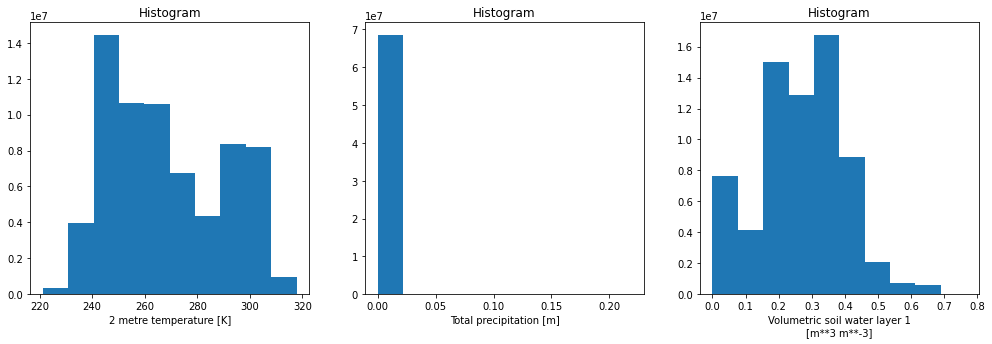

In [34]:
fig, axes = plt.subplots(ncols=3)
fig.set_figheight(5)
fig.set_figwidth(17)

t2m.plot.hist(ax=axes[0])
tp.plot.hist(ax=axes[1])
swvl1.plot.hist(ax=axes[2])

plt.draw()

The process of transformation to handle the skewness could be:
1. Applying various transfomations on the data
2. Determine which transformation yields the best distribution (by plotting histograms and picking the graph which closely resembles normal distribution)

(array([24913495.,        0.,        0.,  6602140.,  8163657., 11066456.,
        10153525.,  6054693.,  1615693.,    29094.]),
 array([-18.714973 , -16.995394 , -15.275813 , -13.556233 , -11.836654 ,
        -10.117073 ,  -8.397493 ,  -6.677913 ,  -4.9583335,  -3.2387533,
         -1.5191733], dtype=float32),
 <a list of 10 Patch objects>)

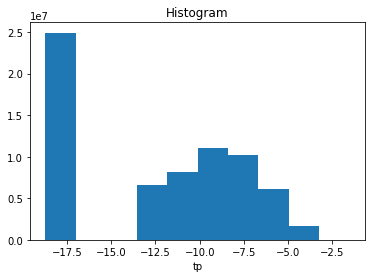

In [6]:
#Various transformations
tp_log = np.log(tp) 
tp_sqrt = np.sqrt(tp)
tp_tanh = np.tanh(tp)
#tp_boxcox = stats.boxcox(tp)
tp_log.plot()

In [37]:
stats.boxcox(tp)

ValueError: ignored

Plotting colormaps of all 3 datasets for the day of 15th December

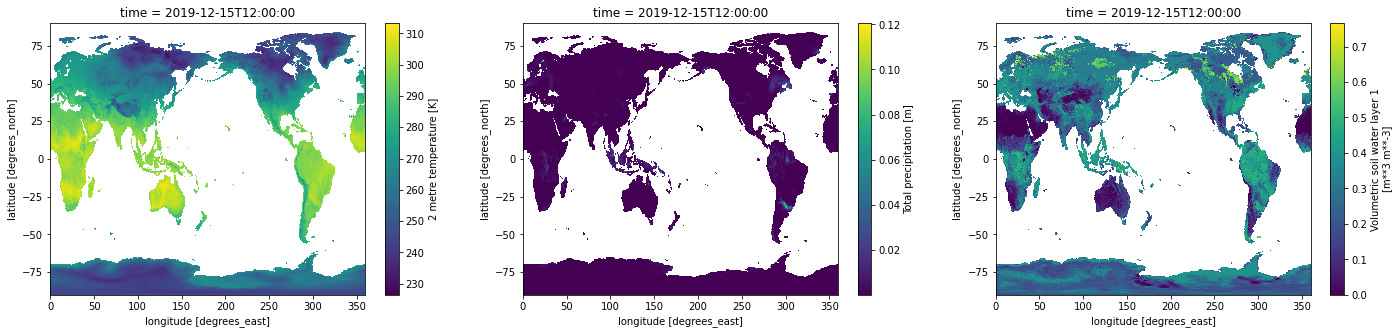

In [11]:
t = 14
t2m_plot = ds.t2m.isel(time=t)
tp_plot = ds.tp.isel(time=t)
swvl1_plot = ds.swvl1.isel(time=t)

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(24, 5))
t2m_plot.plot(ax=ax1)
tp_plot.plot(ax=ax2)
swvl1_plot.plot(ax=ax3)

As it is observed from the above colormaps, it's clear the temperature, precipitation and volumetric soil water across the globe on the day of 15th December, 2019.

**Temperature**: The bluish dark tint indicates lower temperatures all the way to yellow tint that indicates higher temperatures. As evident from the map, the hotter regions comprise of the locations near the equator such as whole of south asia, almost all of australia and some parts of northern and central parts of south america. The most colder regions on this particular day on earth seems to be some parts of Russia, most of greenland and northern region of north america.

**Precipitation:** Looking at the visualisation, it seems like on this particular day, very few parts of the world witnessed precipitation. Some parts of south africa, eastern side of north america, and some parts of south-west africa witnessed some level of precipitation whereas region of paraguay and uruguay (southern region of south america) witnessed heavy precipitation.

**Volumetric Soil Water:** The map shows a lot of green, indicating the values of VSW to be around 0.3 to 0.5 m^3. As it is evident from the map, the region of the sahara desert, as well as other blue regions of the map has little to no soil water, as expected.

*An important thing to note here is, it can be seen that the regions where total precipitation is more, the temperature and volumetric soil water is also more, showing direct relation of the two factors on total precipiration.*

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


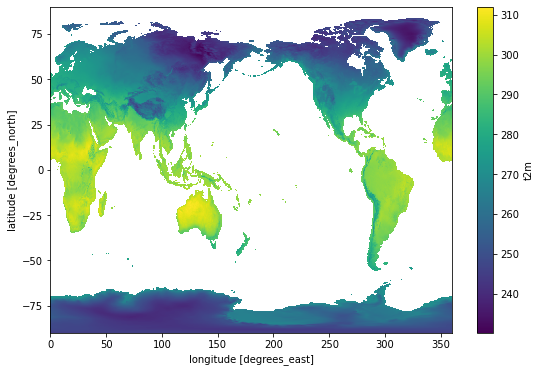

In [26]:
t2m.mean(dim='time').plot(size=6)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


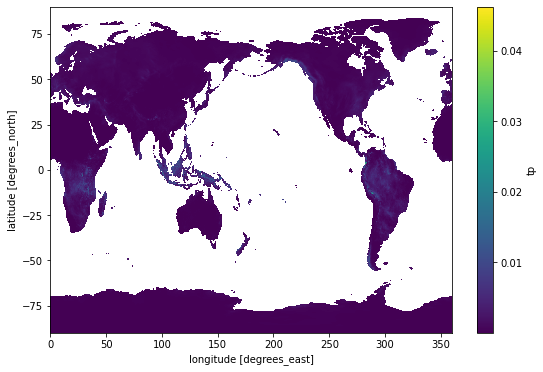

In [110]:
tp.mean(dim='time').plot(size=6)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


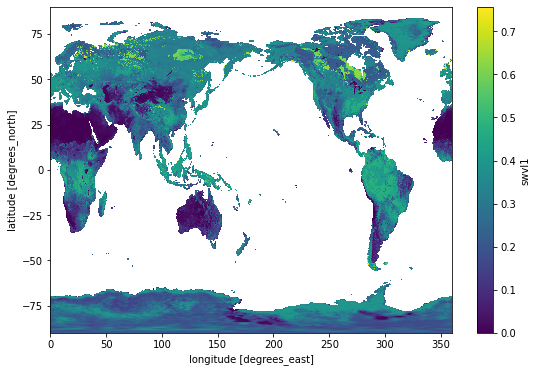

In [109]:
swvl1.mean(dim='time').plot(size=6)

#### Performing Linear Interpolation (Upscaling)
As required, now interpolaing the 3 datasets from 0.1 degree spatial resolution to 0.05 degree

#### The Neural Network

In [25]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        
        x = x.view(-1,224*4*4)
        
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        
        x = self.softmax(self.fc5(x))
        
        return x

print(Net())

Net(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
#Making an object of the Net class
model = Net().to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

In [113]:
# Initialising Hyperparameters
epochs = 100
steps = 0
print_every = 100
trainLoss = [] 
testLoss = []

batch = 32

In [ ]:
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1   # Forward pass
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        optimizer.zero_grad()
        log_ps = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = criterion(log_ps, labels)
        loss.backward()   # Backward pass
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
                    log_ps = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    test_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    
                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            trainLoss.append(running_loss/len(train_loader))
            testLoss.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, epochs),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [ ]:
#Visualizing Loss
plt.plot(trainLoss, label = 'Training Loss')
plt.plot(testLoss, label = 'Validation Loss')
plt.legend(frameon = False)

In [ ]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

finalTest = test.values/255

finalTest = torch.from_numpy(finalTest)

temp = np.zeros(finalTest.shape)
temp = torch.from_numpy(temp)

data = torch.utils.data.TensorDataset(finalTest, temp)

submissionLoader = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = False)

submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in submissionLoader:
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        log_ps = model(images.type(torch.FloatTensor).to(device))
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1